In [1]:
import netket as nk
import netket.experimental as nkx

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
L = 4  # Side of the square
graph = nk.graph.Square(L)
N = graph.n_nodes

In [3]:
N_f = 1
hi = nkx.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions_per_spin=(N_f,N_f))

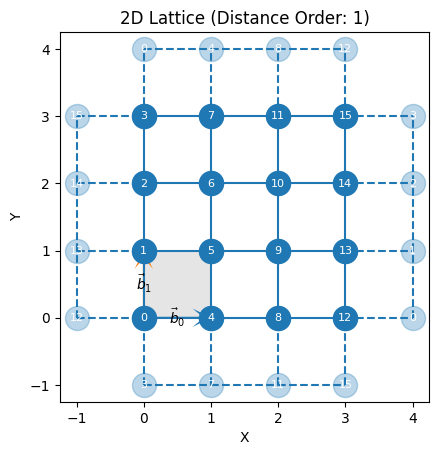

In [4]:
graph.draw();

In [5]:
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc

In [6]:
t = 1.0
U = 0.0

H = 0.0
for (i, j) in graph.edges():
    H -= t * (cdag(hi,i,1) * c(hi,j,1) + cdag(hi,j,1) * c(hi,i,1))
    H -= t * (cdag(hi,i,-1) * c(hi,j,-1) + cdag(hi,j,-1) * c(hi,i,-1))
for i in graph.nodes():
    H += U * nc(hi,i,1) * nc(hi,i,-1)

In [7]:
from scipy.sparse.linalg import eigsh
sp_h = H.to_sparse()
eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
E_gs = eig_vals[0]
print("Exact ground state energy:", E_gs)

Exact ground state energy: -8.000000000000002


In [11]:
import jax
import jax.numpy as jnp

# Note: This function can also be found inside of netket, in `nk.jax.logdet_cmplx`, but we implement it here
# for pedagogical purposes.
def _logdet_cmplx(A):
    sign, logabsdet = jnp.linalg.slogdet(A)
    return logabsdet.astype(complex) + jnp.log(sign.astype(complex))

In [8]:
import flax.linen as nn
from netket.utils.types import NNInitFunc
from netket.nn.masked_linear import default_kernel_init
from netket import jax as nkjax
from typing import Any, Callable, Sequence
from functools import partial
DType = Any

In [9]:
class LogSlaterDeterminant(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    def setup(self):
        self.Mup = self.param('Mup', self.kernel_init, 
                   (self.hilbert.n_orbitals, self.hilbert.n_fermions_per_spin[0]), 
                   self.param_dtype)   
        self.Mdown = self.param('Mdown', self.kernel_init, 
                   (self.hilbert.n_orbitals, self.hilbert.n_fermions_per_spin[1]), 
                   self.param_dtype) 

    @nn.compact
    def __call__(self, n):
        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #Find the positions of the occupied orbitals 
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            Rup = R[0:self.hilbert.n_fermions_per_spin[0]]
            Rdown = R[self.hilbert.n_fermions_per_spin[0]:] - self.hilbert.n_orbitals
            
            # Extract the Nf x Nf submatrix of M corresponding to the occupied orbitals
            Aup = self.Mup[Rup]
            Adown = self.Mdown[Rdown]

            #return _logdet_cmplx(Aup) + _logdet_cmplx(Adown)
            return nkjax.logdet_cmplx(Aup) + nkjax.logdet_cmplx(Adown)

        return log_sd(n)

In [12]:
# Create a neural backflow wave function
model = LogSlaterDeterminant(hi, param_dtype=complex)

# Define a Metropolis exchange sampler
#sa = nk.sampler.MetropolisExchange(hi, graph=graph)
sa = nkx.sampler.MetropolisParticleExchange(
    hi, graph=graph, n_chains=16, exchange_spins=False, sweep_size=64
)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=512, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05, holomorphic=True)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bfsd_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=bfsd_log)

100%|██████████| 300/300 [01:39<00:00,  3.03it/s, Energy=-8.0000012+0.0000042j ± 0.0000042 [σ²=0.0000000, R̂=1.0143]]


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [20]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -8.00003+0.00000j ± 0.00013 [σ²=0.00001, R̂=1.0095]
Relative error   : 4.057423110989973e-06


In [13]:
class LogNeuralBackflow(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    hidden_units: int
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    @nn.compact
    def __call__(self, n):
       
        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #Bare Slater Determinant (N x Nf matrix of the orbital amplitudes) 
            #Mup = self.param('Mup', self.kernel_init, (self.hilbert.n_orbitals, self.hilbert.n_fermions_per_spin[0],), self.param_dtype)
            #Mdown = self.param('Mdown', self.kernel_init, (self.hilbert.n_orbitals, self.hilbert.n_fermions_per_spin[1],), self.param_dtype)

            # Construct the Backflow. Takes as input strings of $N$ occupation numbers, outputs an $N x Nf$ matrix
            # that modifies the bare orbitals.
            Fup = nn.Dense(self.hidden_units, param_dtype=self.param_dtype)(n)
            Fup = jax.nn.relu(Fup)
            # last layer, outputs N x Nf values
            Fup = nn.Dense(self.hilbert.n_orbitals * self.hilbert.n_fermions_per_spin[0], param_dtype=self.param_dtype)(Fup)
            #Mup += Fup.reshape(Mup.shape)
            Mup = Fup.reshape((self.hilbert.n_orbitals, self.hilbert.n_fermions_per_spin[0]))
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            Aup = Mup[R[:self.hilbert.n_fermions_per_spin[0]]]
            
            Fdown = nn.Dense(self.hidden_units, param_dtype=self.param_dtype)(n)
            Fdown = jax.nn.relu(Fdown)
            Fdown = nn.Dense(self.hilbert.n_orbitals * self.hilbert.n_fermions_per_spin[1], param_dtype=self.param_dtype)(Fdown)
            Mdown = Fdown.reshape((self.hilbert.n_orbitals, self.hilbert.n_fermions_per_spin[1]))
            #Mdown += Fdown.reshape(Mdown.shape)
            #Find the positions of the occupied, backflow-modified orbitals
            Adown = Mdown[R[self.hilbert.n_fermions_per_spin[0]:]-self.hilbert.n_orbitals]
            return _logdet_cmplx(Aup) + _logdet_cmplx(Adown)

        return log_sd(n)

In [14]:
# Create a neural backflow wave function
model = LogNeuralBackflow(hi, hidden_units=N, param_dtype=complex)

# Define a Metropolis exchange sampler
sa = nkx.sampler.MetropolisParticleExchange(
    hi, graph=graph, n_chains=16, exchange_spins=False, sweep_size=64
)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05, holomorphic=True)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bfsep_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=2000, out=bfsep_log)

100%|██████████| 2000/2000 [1:43:47<00:00,  3.11s/it, Energy=-11.383-0.001j ± 0.018 [σ²=1.340, R̂=1.0030]]


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [16]:
sep_energy = vstate.expect(H)
#error = abs((sep_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sep_energy}")
#print(f"Relative error   : {error}")

Optimized energy : -11.347-0.011j ± 0.019 [σ²=1.374, R̂=1.0017]


In [48]:
class LogFullNeuralBackflow(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    hidden_units: int
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    @nn.compact
    def __call__(self, n):
       
        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #print(n.shape)
            #Bare Slater Determinant (N x Nf matrix of the orbital amplitudes) 
            M = self.param('M', self.kernel_init, (2 * self.hilbert.n_orbitals, self.hilbert.n_fermions,), self.param_dtype)

            # Construct the Backflow. Takes as input strings of $N$ occupation numbers, outputs an $N x Nf$ matrix
            # that modifies the bare orbitals.
            F = nn.Dense(self.hidden_units, param_dtype=self.param_dtype)(n)
            F = jax.nn.tanh(F)
            # last layer, outputs N x Nf values
            F = nn.Dense(2 * self.hilbert.n_orbitals * self.hilbert.n_fermions, param_dtype=self.param_dtype)(F)
            # reshape into M and add
            M += F.reshape(M.shape)
            
            #Find the positions of the occupied, backflow-modified orbitals
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            A = M[R]
            return _logdet_cmplx(A)

        return log_sd(n)

In [50]:
# Create a neural backflow wave function
model = LogFullNeuralBackflow(hi, hidden_units=N)

# Define a Metropolis exchange sampler
sa = nkx.sampler.MetropolisParticleExchange(
    hi, graph=graph, n_chains=16, exchange_spins=False, sweep_size=64
)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bf_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=2000, out=bf_log)

100%|██████████| 2000/2000 [1:16:18<00:00,  2.29s/it, Energy=-11.631+0.000j ± 0.018 [σ²=1.366, R̂=1.0010]]


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [51]:
full_energy = vstate.expect(H)
error = abs((full_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {full_energy}")
print(f"Relative error   : {error}")

Optimized energy : -11.624-0.000j ± 0.018 [σ²=1.416, R̂=1.0030]
Relative error   : 0.020641524006885452


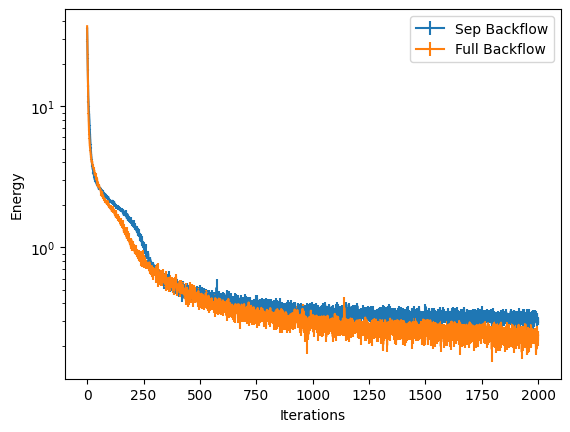

In [57]:
logged_data = (bfsep_log.data, bf_log.data)
labels = ("Sep Backflow","Full Backflow")
E_gs = -11.868835569563949
from matplotlib import pyplot as plt

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters, data["Energy"].Mean.real-E_gs, yerr=data["Energy"].Sigma,label=label)

#plt.hlines([E_gs], xmin=0, xmax=2000, color='black', label="Exact")
#plt.ylim(-12, 25)
# Set the scale to be y-log
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()